# Пример с табличными данными

Александр Дьяконов, 2020

Использованы материалы:
* https://atcold.github.io/pytorch-Deep-Learning/

In [5]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np

from matplotlib import pyplot as plt

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### данные

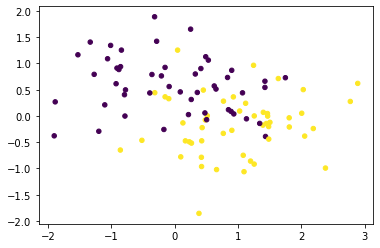

In [7]:
from sklearn.datasets import make_moons, make_gaussian_quantiles
#X, y = make_gaussian_quantiles(mean=None, cov=1.0, n_samples=100, n_features=2, n_classes=3, shuffle=True, random_state=1)
X, y = make_moons(n_samples=100, shuffle=True, noise=0.5, random_state=1)
plt.scatter(X[:,0], X[:,1], 20, y)

In [8]:
X = torch.from_numpy(X.astype(np.float32)).to(device)
y = torch.from_numpy(y.astype(np.float32)).to(device)

In [9]:
X[:3,:], y[:3]

(tensor([[ 1.3994,  0.0692],
         [ 2.0519, -0.3838],
         [-0.1691, -0.2576]], device='cuda:0'),
 tensor([1., 1., 0.], device='cuda:0'))

In [10]:
X = X.to(torch.float32)
y = y.to(torch.long)

In [15]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

## Модель

In [16]:
# линейная
model = nn.Sequential(nn.Linear(2, 10),
                      nn.Linear(10, 3))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 1e-2
lambda_l2 = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

model.train()

n_epoches = 100

for t in range(n_epoches):
    # небольшой датасет - сразу по всему!
    y_pred = model(X)
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    
    optimizer.zero_grad() # zero the gradients before running the backward pass.
    
    loss.backward()  # Backward pass to compute the gradient of loss w.r.t our learnable params.
      
    optimizer.step()
    
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=3, bias=True)
)

In [17]:
# служебная функция

from matplotlib import pyplot as plt

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

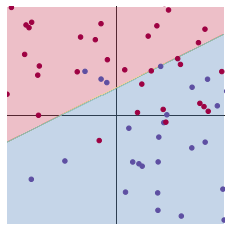

In [18]:
plot_model(X, y, model)

In [27]:
# НЕ линейная
model = nn.Sequential(nn.Linear(2, 100),
                      nn.Sigmoid(),
                      nn.Dropout(0.2),
                      nn.Linear(100, 100),
                      nn.Sigmoid(),
                      nn.Dropout(0.2),
                      nn.Linear(100, 3))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 1e-1
lambda_l2 = 1e-7
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # built-in L2

model.train()

n_epoches = 1000

for t in range(n_epoches):
    
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    
    optimizer.zero_grad() # zero the gradients before running the backward pass.
    
    loss.backward()  # Backward pass to compute the gradient of loss w.r.t our learnable params.
      
    optimizer.step()
    
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=100, out_features=3, bias=True)
)

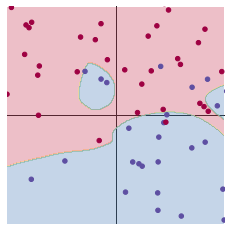

In [28]:
plot_model(X, y, model)

# Регрессия

In [31]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
y = X.pow(2) - X.abs().log() + 0.2 * torch.rand(X.size()).to(device)

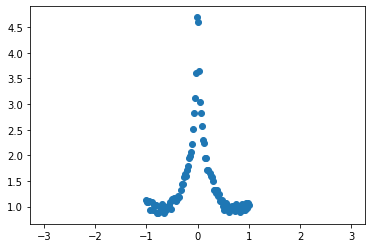

In [32]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

In [33]:
# нелинейная
model = nn.Sequential(nn.Linear(1, 100),
                      nn.Sigmoid(),
                      nn.Linear(100, 1))
model.to(device)

criterion = torch.nn.MSELoss()

learning_rate = 1e-3
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

n_epoches = 1000

for t in range(n_epoches):
    
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    
    
    optimizer.zero_grad() # zero the gradients before running the backward pass.
    
    loss.backward()  # Backward pass to compute the gradient of loss w.r.t our learnable params.
      
    optimizer.step()
    
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [34]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


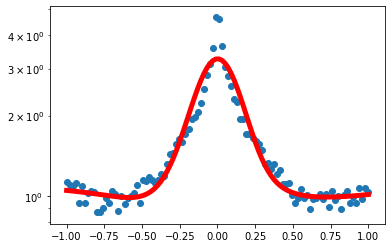

In [35]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.yscale('log')

# Вывод графиков

In [36]:
# датасет для проверки
X2 = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1).to(device)
y2 = X2.pow(2) - X2.abs().log()

In [37]:
train_losses = []
test_losses = []
weights = []
grads = []

def add_info(a, b, c, d):
    train_losses.append(a)
    test_losses.append(b)
    weights.append(c)
    grads.append(d)

In [38]:
# нелинейная
model = nn.Sequential(nn.Linear(1, 100),
                      nn.Sigmoid(),
                      nn.Linear(100, 1))
model.to(device)

criterion = torch.nn.MSELoss()

#learning_rate = 1e-3
#lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoches = 1000

for t in range(n_epoches):
    model.train()
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    train_loss = loss.item()
    print("[EPOCH]: %i, [LOSS]: %.6f" % (t, train_loss))
    display.clear_output(wait=True)
   
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs = model(X2)
        test_loss = criterion(outputs, y2).item()
        
        w_norm = []
        g_norm = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                w_norm.append(param.data.norm().item())
                g_norm.append(param.grad.data.norm().item())
    add_info(train_loss, test_loss, np.mean(w_norm), np.mean(g_norm))

[EPOCH]: 999, [LOSS]: 0.068718


(0, 1)

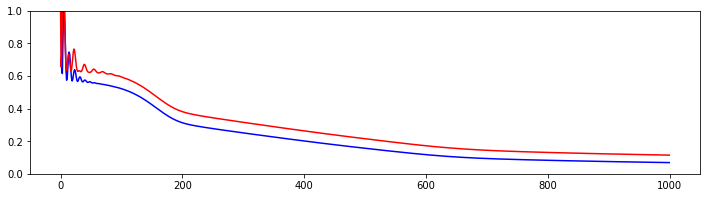

In [39]:
plt.figure(figsize=(12, 3))
plt.plot(train_losses, 'b')
plt.plot(test_losses, 'r')
plt.ylim([0, 1])

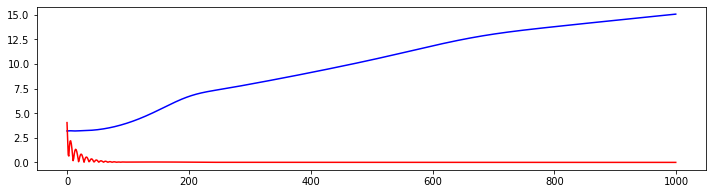

In [40]:
plt.figure(figsize=(12, 3))
plt.plot(weights, 'b')
plt.plot(grads, 'r')

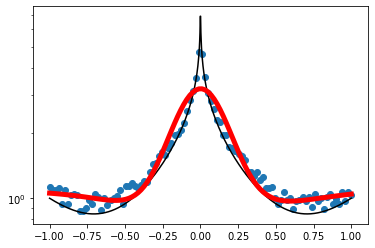

In [41]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X2.data.cpu().numpy(), y2.data.cpu().numpy(), 'k-')
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.yscale('log')

### в tensorboardX
https://github.com/lanpa/tensorboardX/issues/212

In [ ]:
for tag, parm in model.parameters():
     #writer.add_histogram(tag, parm.grad.data.cpu().numpy(), epoch)
        print (tag, parm)

Что мы там в параметрах выводим:

In [160]:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print (param.data.norm().item(), param.grad.data.norm().item())

61.58363342285156 0.0015342180849984288
7.957362651824951 0.0003895937989000231
2.815061092376709 0.01079340185970068
0.0815209150314331 7.29542225599289e-05
